# The Boston Marathon: An analysis of finishing times from 2011 - 2015
By [Peter Chng](http://unitstep.net/)

---
I've ran the Boston Marathon for the past five years (2011-2015, inclusive) and wanted to get an idea for how the participants and their finishing times had changed across those years. 

To do so, I wrote a script to download all the results from `http://boston.r.mikatiming.de/{year}` and aggregated them into a single CSV file. I then loaded that CSV file into Pandas to analyze the data.

Because Boston has qualifying times that limit registration to only faster runners, this race tends to be much faster than other similar-sized marathons.

In [1]:
import time
import datetime

import scipy.stats as spstats
import pandas as pd

%pylab inline
#%matplotlib inline

# Default plot styles.
figsize(15, 5) # Set default figure size.

# Set default colours/styles.
# Requires matplotlib >= 1.4.
plt.style.use('ggplot')
matplotlib.rcParams.update({
    'font.family': 'Arial',
    'axes.titlesize': 20,
})

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Aggregate results taken from: http://boston.r.mikatiming.de/{year}
# Some data wrangling had to be done to get all results into the same format.
results = pd.read_csv('boston-marathon-total.csv')

## What the data looks like

Each row corresponds to a finishing time for a runner for a particular year. In addition to the net finishing time, you also get the gun finishing time, first half split time, {overall, gender, division} finishing place, gender, age group and bib number of the runner.

The age groups generally line up with the age groups used for [Boston qualifying times](http://www.baa.org/Races/Boston-Marathon/Participant-Information/Qualifying.aspx), with the exception of the 18-39 group, which actually contains two BQ age groups: 18-34 and 35-39. I believe the reason for this was the distinction between "open" and "masters" age groups typical at most races. (Masters competitors usually start at age 40)

This data allows us to take a look some interesting properties of runners of the Boston Marathon.

In [3]:
# Example of what the data looks like:
results[results.name_location.str.contains('Chng')]

,year,place,place_gender,place_division,name_location,country,bib,gender,age_group,half_split,finish_net,finish_gun
1548,2011,2478,2288,1549,"Chng, Peter (CAN)",CAN,NaN,M,18-39,01:32:34,03:07:20,03:10:37
25486,2012,3052,2648,1608,"Chng, Peter (CAN)",CAN,3179,M,18-39,01:39:51,03:29:51,03:31:43
48147,2013,5708,4919,2715,"Chng, Peter (CAN)",CAN,2284,M,18-39,01:38:48,03:19:25,03:20:53
64975,2014,3075,2881,1963,"Chng, Peter (CAN)",CAN,2664,M,18-39,01:29:17,03:04:11,03:05:22
97055,2015,3329,3125,2238,"Chng, Peter (CAN)",CAN,2168,M,18-39,01:30:15,03:03:34,03:04:52


## Number of results

Here are the number of results I was able to pull from the website. For some reason, they are all different than the number of finishers listed in the official statistics. (Take, for example, the [2015 statistics](http://registration.baa.org/2015/cf/Public/iframe_Statistics.htm)) I don't know why this is the case, but the differences are likely small enough to be negligible.

2013 had the smallest number of finishers in recent history, because the bombing/terrorist attack at the finish line prevented many from finishing.

2014 was the largest year because the field size was greatly expanded to accomodate the runners who were not able to complete following the terrorist attack in 2013. Interest remained high in 2015, and so the field size remained higher than in prior years.

2012 had a smaller number of finishers than 2011 because of the high temperatures that year. This reduced the number of finishers in two ways:
1. The B.A.A. granted people the ability to defer to 2013, provided they had picked up their bib, so many did not even start.
2. The heat caused a slightly lower finishing rate.

year
2011    23879
2012    21554
2013    17580
2014    31805
2015    26610
dtype: int64

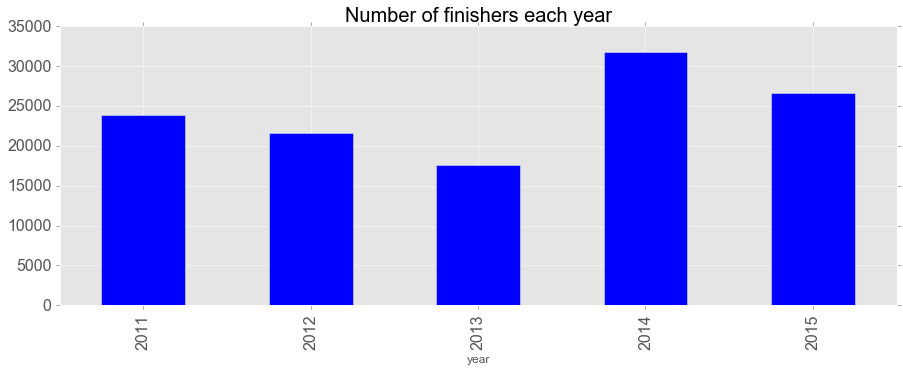

In [4]:
results.groupby('year').size().plot(kind='bar', fontsize=16, title='Number of finishers each year')
results.groupby('year').size()

### Data wrangling

Because the name and country of the runner were combined into one field, we'll extract those into separate fields. We'll also convert the string representation of finishing time (`HH:MM:SS`) into a `pandas.tslib.Timedelta` object, and at the same time, compute the first and second half splits. This will allow us to analyze the finishing times better.

In [5]:
# Data wrangling/data fixing to make the data more useful.

# Extract the name from name_location. (Could have done this in the scraper script, but whatever)
results['name']= results.name_location.map(lambda x : x.rsplit(' ', 1)[0])
# Fix country column, was not extracted properly by the scraper script.
# TODO: PC: Anyway to do this with a Series.str.<method> operation? Series.str.slice() doesn't take non-scalars!
results.country = results.name_location.map(lambda s : s[s.rfind('(') + 1: s.rfind(')')])

# Convert half_split and finish_net to timedelta objects.
def timestring_to_timedelta(time_string):
  if type(time_string) != str:
    return time_string
  parts = time_string.split(':')
  return datetime.timedelta(seconds=int(parts[0])*3600 + int(parts[1])*60 + int(parts[2]))

# Compute first half, second half and finish times as timedelta objects.
results['first_half'] = results.half_split.map(timestring_to_timedelta)
results['finish'] = results.finish_net.map(timestring_to_timedelta) # Based on net finish time.
results['second_half'] = results.finish - results.first_half

# List of years covered.
years = results.year.unique()

In [6]:
print 'Results with missing half_split: {}'.format(results[pd.isnull(results.half_split)].shape[0])

Results with missing half_split: 186


### Missing data

There were 186 results with missing half splits, but none with missing finishing times. This is sort of self-evident, as the results posted on the website **only** included those with finishing times, so the total numbers don't necessarily match up with the official BAA statistics. However, the discrepancies were minor.

For some reason, there were no bib numbers for 2011.

# Demographics across the years

Let's look at some broad statistics between each year. Keep in mind that 2013 was the year of the bombing/terrorist attack, and according to the [official statistics](http://registration.baa.org/2013/cf/Public/iframe_Statistics.htm), only 17,600 runners were allowed to complete, the lowest (75.4%) finishing rate in recent history. This acted as an artificial limit, and as we'll see, this reflects in the major differences in aggregate statistics between 2013 and the other years, making any comparison with 2013 less useful for drawing any inferences.

## Male/Female ratios - in line with other big races

For this, I'm using the number of finishers (male, female) as a proxy for the number that entered. **This is not entirely accurate**, as the number that entered, the number that started, and the number that finished are all distinct values. The definition of each is:

1. **Entered**: Registered and accepted with a BQ, and paid registration fee. (Presumably)
2. **Started**: Showed up, picked up bib, crossed the starting line in Hopkinton. (Again, presumably)
3. **Finished**: Crossed the finish line in Boston.

Each subsequent value is less than or equal to the former. The exact relation is:

    Entered >= Started >= Finished

As an example, see the [2011 Boston Marathon official statistics](http://registration.baa.org/2011/cf/Public/iframe_Statistics.htm).

Because I'm using the number of finishers (my results only capture finishers), the exact ratios of male/female and other demographics may not be correct, if certain groups were more predisposed to not finishing/not starting.

gender,M,W
year,,
2011,57.82%,42.18%
2012,58.40%,41.60%
2013,60.51%,39.49%
2014,55.10%,44.90%
2015,54.82%,45.18%


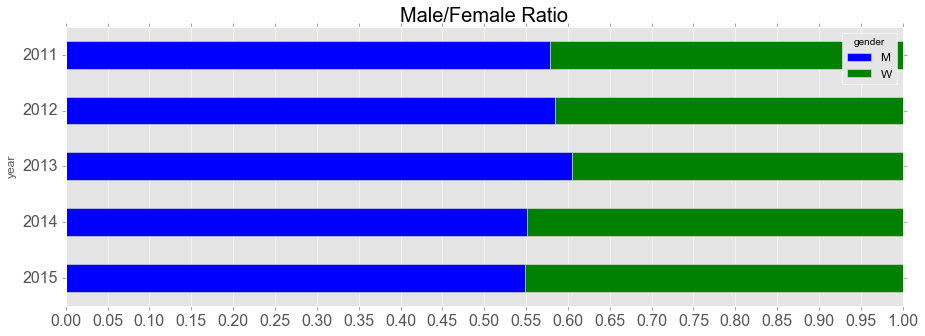

In [7]:
male_female = results.groupby(['year']).gender.value_counts().unstack()
male_female_normed = male_female.div(male_female.sum(1), axis=0)
ax = male_female_normed.plot(kind='barh', stacked=True, fontsize=16, title='Male/Female Ratio')
ax.xaxis.set_major_locator(MultipleLocator(0.05))
ax.invert_yaxis()
# Show raw data
male_female_normed.applymap(lambda x: '{:.2%}'.format(x))

For 2014 and 2015 the male/female ratio was almost identical at 55%/45%. This contrasts with 2011 and 2012, where it was more like M/F 58%/42%.

2013 had a far higher percentage of males than females because the the course was shutdown far earlier than normal following the bombing at the finish line. Since females, on average, are slower than males, this created an artificial limit on the number of females who could finish.

It is interesting to note that that the male ratio has seemingly fallen by 2-3% from 2011/2012 to 2014/2015. **Although I don't have enough years' worth of data**, it is interesting to note that the change lines up with the [change in qualifying standards](http://www.baa.org/races/boston-marathon/participant-information/qualifying/history-of-qualifying-standards.aspx) that happened between 2012 and 2013. This would seem to indicate that the five-minute across-the-board reduction in qualifying times slightly benefited women by increasing their participation. Looking at more years in the past along with more data in the future would confirm or deny this assertion.

However, the current ratio of 55%/45% (M/F) is still inline with other big marathons that have no qualifying time restrictions, such as the [2013 Chicago Marathon](http://nbviewer.jupyter.org/github/pchng/cm2013/blob/master/2013%20Chicago%20Marathon%20Analysis.ipynb).  Other examples:

- The 2015 New York City Marathon (which does have qualifying times, but the vast majority of runners enter through a lottery) had a ratio of 58%/42% (M/F) [according to MarathonGuide.com](http://www.marathonguide.com/results/browse.cfm?MIDD=472151101)
- The 2015 Chicago Marathon (which does have qualifying times, but is still open to non-qualifiers via lottery) had a ratio of 54%/46% (M/F) [according to MarathonGuide.com](http://www.marathonguide.com/results/browse.cfm?MIDD=67151011)
- The 2015 Philly Marathon had a ratio of 55%/45% (M/F) [according to MarathonGuide.com](http://www.marathonguide.com/results/browse.cfm?MIDD=479151122)

Thus, the current BQ standards are "fair" to both males and females in that there is not a marked difference in gender ratios from other big marathons. (An informal survey of MarathonGuide.com results reveals that most marathons are somewhere between 55-60% male)

## Age and gender group distribution

For this comparison, I deliberately excluded 2013 for reasons mentioned above. This allows us to compare the remaining years, where all runners were allowed a chance to finish.

age_group   18-39          40-44          45-49         50-54         55-59  \
gender          M       W      M      W       M      W      M      W      M   
year                                                                          
2011       20.31%  21.78%  9.64%  7.57%  10.70%  6.66%  8.06%  3.58%  4.74%   
2012       20.08%  21.25%  9.35%  7.05%  10.42%  6.67%  8.70%  3.74%  5.00%   
2014       18.56%  21.82%  8.25%  7.31%   9.17%  7.20%  7.76%  4.66%  5.57%   
2015       18.66%  22.59%  7.93%  7.46%   9.34%  6.88%  7.73%  4.53%  5.64%   

age_group         60-64         65-69         70-74         75-79         \
gender         W      M      W      M      W      M      W      M      W   
year                                                                       
2011       1.66%  2.99%  0.70%  0.90%  0.19%  0.41%  0.03%  0.06%  0.01%   
2012       1.84%  3.18%  0.77%  1.20%  0.20%  0.33%  0.06%  0.12%  0.01%   
2014       2.40%  3.46%  1.07%  1.68%  0.37%  0.50%  0.06%  0.13%  0.01%   
2015       2.28%  3.38%  1.01%  1.51%  0.34%  0.46%  0.08%  0.14%  0.01%   

age_group    80+         
gender         M      W  
year                     
2011       0.00%  0.00%  
2012       0.01%  0.00%  
2014       0.03%  0.00%  
2015       0.04%  0.00%

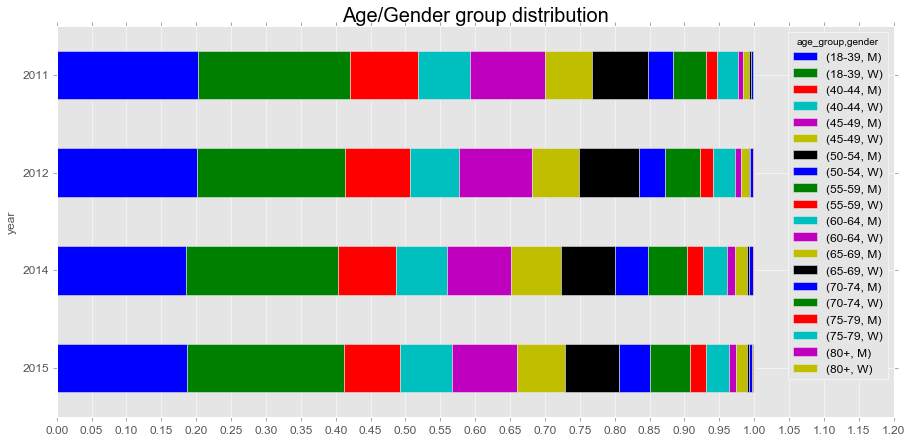

In [8]:
# TODO: PC: Need more colours!
year_age_groups = results[results.year != 2013].groupby(['year', 'gender', 'age_group']).size().unstack().unstack()
year_age_groups_normed = year_age_groups.div(year_age_groups.sum(1), axis=0)
ax = year_age_groups_normed.plot(kind='barh', stacked=True, fontsize=12, figsize=(15, 7),
                                 title='Age/Gender group distribution')
ax.xaxis.set_major_locator(MultipleLocator(0.05))
ax.invert_yaxis()

# Show underlying DataFrame.
year_age_groups_normed.applymap(lambda x: '{:.2%}'.format(x))

Here, we can see a more detailed view of how the 5-minute tightening of BQ standards affected each age group/gender.
First, let's go over a summary of the changes that have happened to Boston registration in the past five years:

- For 2011 registration (which happened in 2010), interest was so high that the race filled up in less than one day. Many people were "shut out", because either they presumed they could wait until after work to register, or the registration website was too slow during the day.
- For 2012 registration, the BAA introduced a process by which they would essentially accept all registrations for a period of time, and then only accept the fastest (runners who had beaten their BQ by the largest amount) up until the race had filled. BQ times were not changed yet, for various reasons.
- For 2013 and onwards, BQ times were reduced by 5 minutes for every age group/gender; the new registration process was also retained.

These changes seem to have reduced the percentage of various groups in the Boston Marathon. For instance, the M18-39 group is noticeably smaller in 2014/2015 after remaining almost constant in 2011/2012.

In particular, **the tighter qualifying times seemed to reduce the percentage size of all male age groups up to and including 50-54**, after which the change was too small or actually in favour of the new BQ times. It should be noted that the older age groups have far fewer participants, so it's harder to draw conclusions since various fluctuations can affect the percentage much more. Again, I'm only looking at two years' worth of data (two before and two after the change), so take this all with a grain of salt.

It's important to note that I am not arguing for or against any of the changes the BAA has made, just observing changes that *may* have happened as a result of it. Whether you are for/against/indifferent to the changes depends on your point-of-view.

### Largest Age Group: 40-44 or 45-49

age_group,18-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80+
year,,,,,,,,,,
2011,42.10%,17.21%,17.37%,11.63%,6.40%,3.69%,1.09%,0.44%,0.07%,0.01%
2012,41.33%,16.40%,17.09%,12.45%,6.84%,3.94%,1.40%,0.40%,0.13%,0.01%
2014,40.38%,15.56%,16.37%,12.43%,7.97%,4.52%,2.05%,0.56%,0.14%,0.03%
2015,41.25%,15.39%,16.22%,12.26%,7.91%,4.39%,1.86%,0.54%,0.14%,0.04%


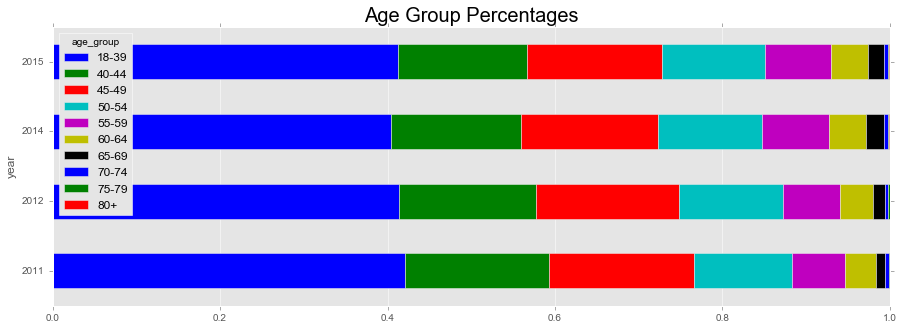

In [9]:
age_group = results[results.year != 2013].groupby(['year', 'age_group']).size().unstack()
age_group_normed = age_group.div(age_group.sum(1), axis=0)
age_group_normed.plot(kind='barh', stacked=True, title='Age Group Percentages')
age_group_normed.applymap(lambda x: '{:.2%}'.format(x))

At first glance, the 18-39 age group is clearly the largest, accounting for >40% of the entire field across all years. However, this is expected since this age group spans the most number of years. With the exception of the 80+ age group, all other age groups span only five years. (I don't know why Boston defines age groups this way, but it's probably because of the division between the 'open' and 'masters' fields, with master-age competitors typically beginning at age 40)

**There is no way to properly breakdown the 18-39 age group without actually knowing the runners' ages**, but a crude approximation would be to note that this age group spans 22 years, and that this is 4.4 times the size of the five-year age groups. Assuming a uniform distribution within 18-39 (likely not the case), we "normalize" this age group by dividing by 4.4, yielding a **normalized result of 9-9.5%**. 

This would mean that the **largest five-year age group, by far, is either 40-44 or 45-49**. You can draw your own conclusions as to why this might be the case. My personal explanation is that younger folks have other things on their mind, and that the training and recovery necessary for getting a BQ is tougher at older ages.

The 40-49 age range seems to be the "sweet spot" where these folks have the {time, interest, money} to train and qualify for Boston, while not being old enough to make it too hard.

## Countries/Nationalities Represented

Almost all races have a huge local bias, and Boston is no different, with over 80% of all runners over the past five years being from the USA. 

Canada and the United Kingdom (which is abbreviated as GBR) are consistently second and third. The distribution over the remainder of the countries appears to follow some power-law distribution, with the amounts getting progressively smaller, though I didn't bother to confirm this.

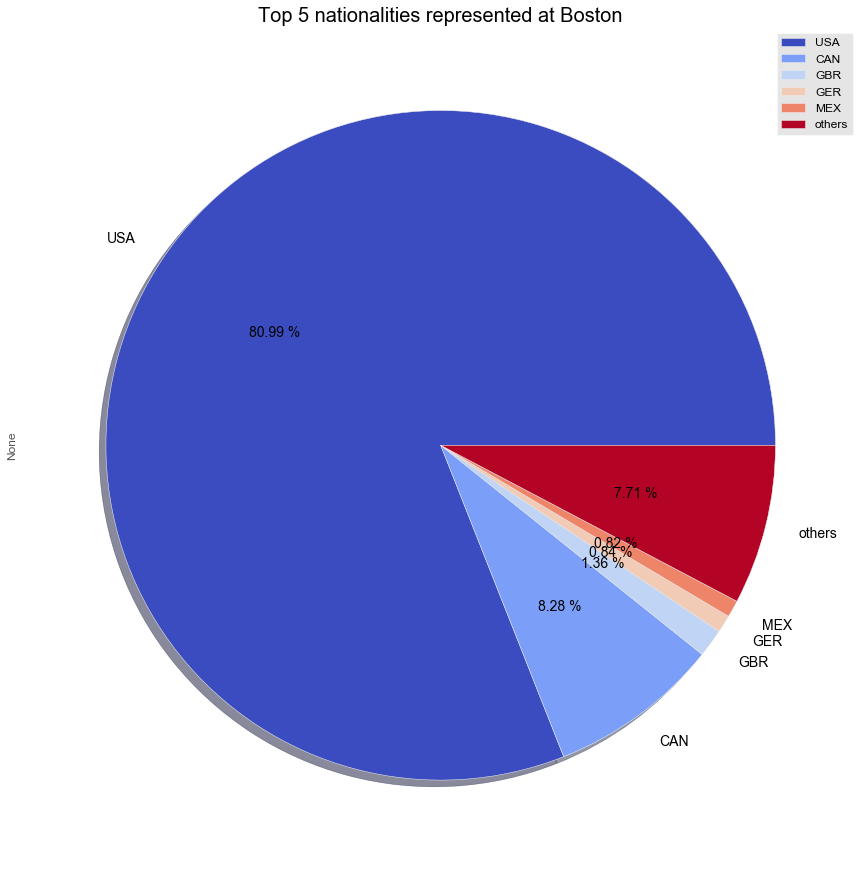

In [10]:
country_counts_sorted = results.groupby('country').size().sort_values(ascending=False)

def top_n_group_other(s, n, label='others'):
    top_n = s.sort_values(ascending=False)[:n]
    top_n[label] = s[n:].sum()
    return top_n

n_countries = 5
top_n_group_other(country_counts_sorted, n_countries).plot(
    kind='pie', autopct='%.2f %%', figsize=(15, 15), colormap='coolwarm', shadow=True, legend=True,
    fontsize=14,title='Top {} nationalities represented at Boston'.format(n_countries))

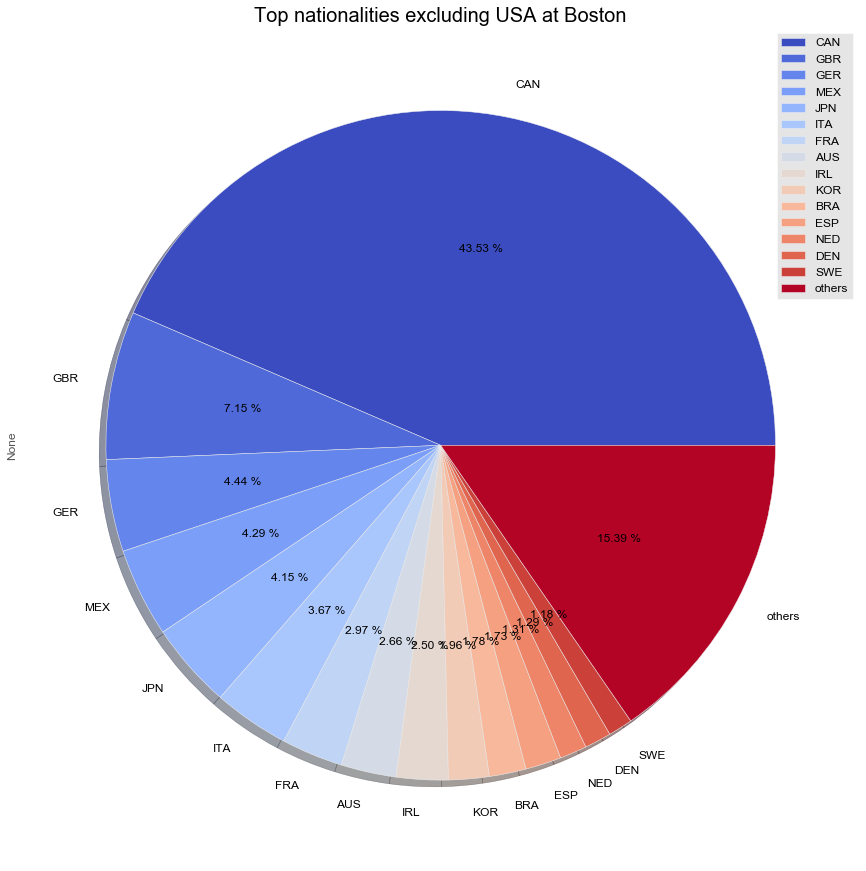

In [11]:
# Non-US countries: Does this follow some sort of power-trend law, i.e. the decrease between subsequent numbers?
top_n_group_other(country_counts_sorted[1:], 15).plot(
    kind='pie', autopct='%.2f %%', figsize=(15, 15), colormap='coolwarm', shadow=True, legend=True,
    fontsize=12, title='Top nationalities excluding USA at Boston')

# Finishing times across the years

Finishing times are always an interesting topic, not only because they tend to be the main goal of most runners, but also because they provide a nice insight into how changing conditions and demographics between the years might affect overall performance.

,count,mean,median,10%,std,min,max
year,,,,,,,
2011,23879,03:49:54.168893,03:44:58,03:06:48,00:37:56.759795,02:03:02,07:37:43
2012,21554,04:18:27.013222,04:11:04,03:23:02,00:48:43.086251,02:12:40,07:55:15
2013,17580,03:29:52.782707,03:31:17,02:58:18,00:23:07.668708,02:10:22,04:44:14
2014,31805,04:02:30.294702,03:52:14,03:04:47.400000,00:50:52.411473,02:08:37,08:58:53
2015,26610,03:46:28.649605,03:39:41.500000,03:00:04,00:40:31.902086,02:09:17,08:06:01


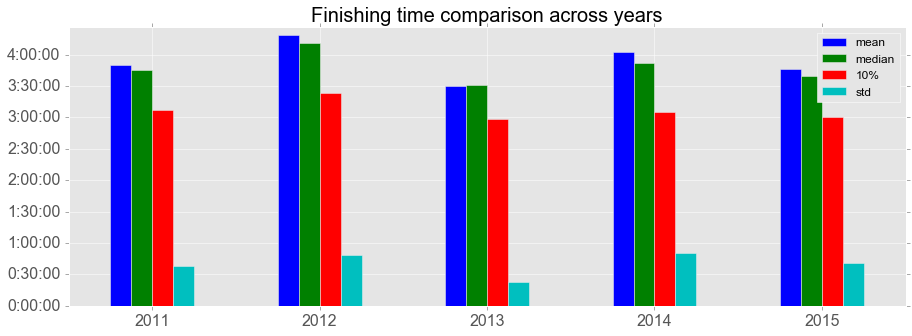

In [12]:
# Pandas doesn't support aggregate operations (mean(), etc.) on GroupBy objects for Timedelta/timedelta64[ns]:
# https://github.com/pydata/pandas/issues/5724
year_describe_comparison = results.groupby(['year'])['finish']\
    .describe(percentiles=[0.10, 0.50]).unstack()\
    .reindex(columns=['count', 'mean', '50%', '10%', 'std', 'min', 'max'])\
    .rename(columns={'50%': 'median'})
ax = year_describe_comparison.drop(['count', 'max', 'min'], axis=1)\
    .applymap(lambda t: t/np.timedelta64(1, 's') if isinstance(t, pd.tslib.Timedelta) else t)\
    .plot(kind='bar', title='Finishing time comparison across years', fontsize=16, rot=0)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: str(datetime.timedelta(seconds=x))))
ax.yaxis.set_major_locator(MultipleLocator(30*60))
ax.set_xlabel('')

# Show dataframe for reference
year_describe_comparison.applymap(lambda t: t.to_pytimedelta() if isinstance(t, pd.tslib.Timedelta) else t)

### Boston - much faster than the rest

In ideal years, the mean finishing time in Boston is in the high 3:40's. For comparison, the Chicago Marathon (comparable in size), considered "fast and flat", has had mean finishing times in the 4:30's for the past few years. A ~40-50 minute difference in mean times is quite a big difference. Thus, it's no surprise that Boston itself is [among the marathons with the highest percentage of Boston qualifying times](http://www.marathonguide.com/races/BostonMarathonQualifyingRaces.cfm?Year=2015).

### Fastest full year - 2015
The fastest year was 2013, where, because of the bombing/terrorist attack at the finish line, only the fastest runners were permitted to finish.

Outside of this year, the fastest was 2015 in my five-year sample set. This is interesting, because there was a considerable amount of rain and crosswinds during that year. It didn't seem to have an effect on most runners, myself included. (2015 was my fastest Boston) In particular, it was considerably faster than 2014, a year where weather conditions were [considered ideal](http://www.accuweather.com/en/weather-news/boston-marathon-weather-forecast/25683022), but may have been on the warm side for many, rising to a high of 62F/17C.

2012 was by far the slowest year, owing to the [heat during that year](http://www.baa.org/races/boston-marathon/boston-marathon-history/weather-conditions.aspx).

### Median faster than Mean - distribution not symmetric
In almost all years, the median was faster than the average/mean, except for 2013, where only the faster runners were permitted to finish. This is likely to there being more "slower" runners than "faster" runners, creating an asymmetric distribution.

### A lot of sub-3 runners
I've also shown the fastest 10th percentile time; this is the time that the fastest 10% of runners met, or in another words, if you ran this time or faster, you were in the top 10% of all finishers. As you can see, it's always been around the 3-hour mark, except for the hot 2012 year. This is pretty significant, when you consider that in most other marathon races without qualifying times, running a sub-3 will get you into the top 2-3%. This gives you an ideal for just how competitive the overall field is in Boston.

In [13]:
increase_2014_2015_mean = (year_describe_comparison.ix[2014]['mean'] / year_describe_comparison.ix[2015]['mean'] - 1)
increase_2014_2015_std = (year_describe_comparison.ix[2014]['std'] / year_describe_comparison.ix[2015]['std'] - 1)
print '2014-2015 increase in mean={:.2%}, std={:.2%}'.format(increase_2014_2015_mean, increase_2014_2015_std)

2014-2015 increase in mean=7.08%, std=25.52%


## Heat and finishing times - Mean and Standard Deviation affected differently

Obviously, heat has a detrimental effect on running pace; that should be no surprise to any serious runner. What's more interesting, however, is that it appears to affect runners differently, at least in the Boston Marathon.

Now, mind you, I have only five years' worth of data, so that is likely not enough to draw any conclusions, but it's still worthwhile to note that the two hottest years (2012 and 2014, where the highs were 87F/31C and 62F/17C, respectively) had **the highest standard deviation (48:43 and 50:52) in finishing times.**

In cooler years, the standard deviation was much lower. The increased standard deviation in hotter years is not simply explained by each runner slowing down by a percentage of their "ideal" finishing time, as that would result in the mean and standard deviation both increasing by the same percentage, but this did not occur.

For example, let's compare 2015 (cool year) with 2014 (a warmer year): 2014 had a mean that was **7.08%** higher and a standard deviation that was **25.52%** higher than 2015.

The exact relation between finishing times and heat is difficult to determine from the data I have, as there are other variables at play, including (but not limited to), other weather conditions, BQ cut-off times for the year, etc. that also affect finishing times. But it's clear to me that it's not simply a case of each runner slowing down by a fixed percentage off of their "ideal" time.

Instead, it's likely that slower runners are affected more, perhaps because they are out on the course for a longer time and during the hotter part of the day. In particular, it's worthwhile to note that Boston starting times are [done in stages/waves](http://www.baa.org/races/boston-marathon/participant-information.aspx), with slower runners starting progressively later in the day, when it's likely hotter. (The start is also later than most marathons)

### Statistics Aside: Demonstrating that if all runners slowed by a fixed percentage, mean and standard deviation would increase by the same proportion/percentage:

This may not be obvious (at least it wasn't to me), so we'll do a quick explanation.

Suppose the "ideal" distribution of finishing times, $x$, has a mean and variance for the entire population given by: (Standard deviation would just be the square root of variance)

$$ \bar{x} = {1 \over N} \sum_{i=1}^{N} x_i $$
$$ s_x^2 = {1 \over N} \sum_{i=1}^{N} (x_i - \bar{x})^2 $$

Now, suppose all finishing times are slowed by a fixed percentage (say, because of heat) to create a new distribution, $y$, where $y = ax$ and $a > 1$.
Then the new population mean is:

$$ \bar{y} = {1 \over N} \sum_{i=1}^{N} ax_i $$
$$ \bar{y} = {a \over N} \sum_{i=1}^{N} x_i $$
$$ \bar{y} = a\bar{x} $$

And the new population variance is:

$$ s_y^2 = {1 \over N} \sum_{i=1}^{N} (ax_i - \bar{y})^2 = {1 \over N} \sum_{i=1}^{N} (ax_i - a\bar{x})^2 $$
$$ s_y^2 = {1 \over N} \sum_{i=1}^{N} (a^2x_i^2 - 2a^2x_i\bar{x} + a^2\bar{x}^2) $$
$$ s_y^2 = {a^2 \over N} \sum_{i=1}^{N} (x_i^2 - 2x_i\bar{x} + \bar{x}^2) $$
$$ s_y^2 = {a^2 \over N} \sum_{i=1}^{N} (x_i - \bar{x})^2 $$
$$ s_y^2 = a^2s_x^2 $$

Since standard deviation is just the square root of the variance:

$$ s_y = \sqrt{a^2s_x^2} = as_x $$

This shows that both the population mean and standard deviation would be scaled by the same amount if all runners slowed by a fixed percentage.

Since this did not occur, and instead the standard deviation increased by a greater percentage than the mean, we conclude that heat does not slow down all runners by the same percentage.

# Distribution of finishing times

Looking at the distribution/histogram of finishing times often gives a more useful insight than just looking at the mean and standard deviation.

## 2013 Distribution: Only comparable up to ~3:30

Note that the 2013 distribution is not directly comparable to other years as not all runners were allowed to finish. The course would have been shut down sometime before 3:00 PM local time, and since the last wave started at 11:15 AM, this probably had an impact on the distribution after the 3:30 mark; thus the distribution is probably comparably up to, but not after, the 3:30 time.

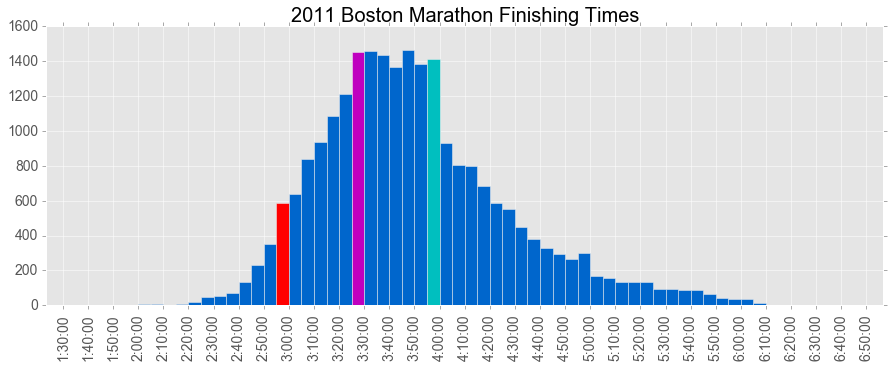

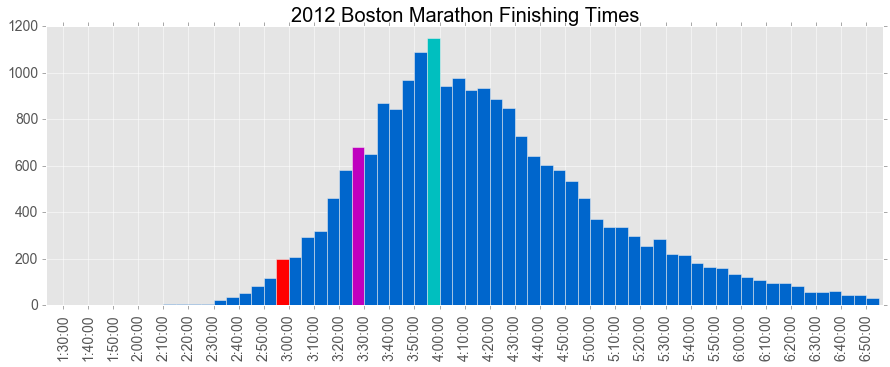

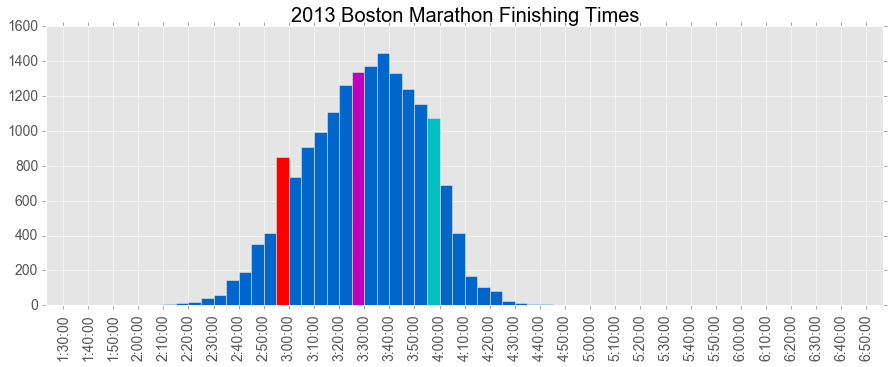

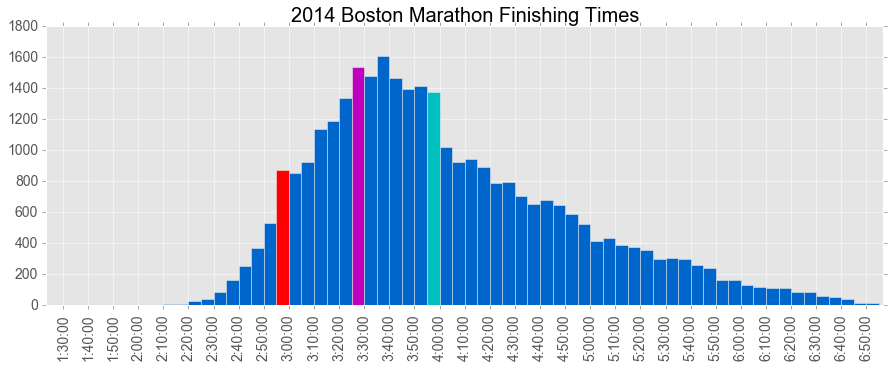

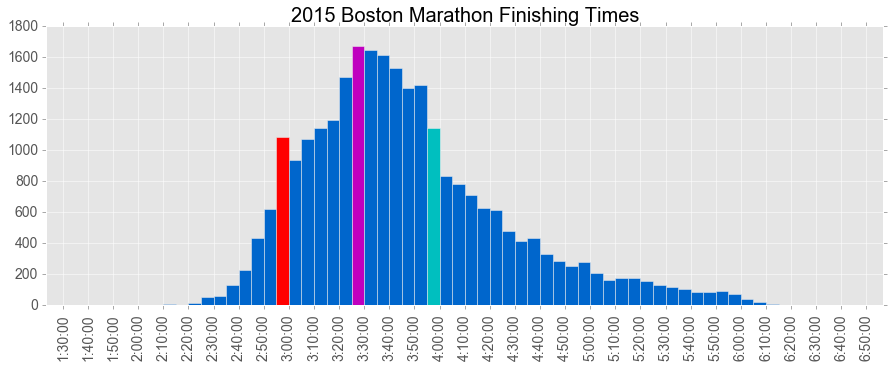

In [14]:
bins = [7200 + i *5*60 for i in range(5*12)]
results['raw_finish'] = results.finish.map(lambda t: t/np.timedelta64(1, 's'))
for year in years:
    pyplot.subplots()
    ax = results[results.year == year].raw_finish.hist(
        bins=bins, xrot=90, xlabelsize=14, ylabelsize=14, color=(0, 0.4, 0.8))
    ax.set_title('{} Boston Marathon Finishing Times'.format(year))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: str(datetime.timedelta(seconds=x))))
    ax.xaxis.set_major_locator(MultipleLocator(10*60))
    # Highlight {2:55-3:00, 3:25-3:30 3:55-4:00} bins.
    ax.patches[11].set_facecolor('r')
    ax.patches[17].set_facecolor('m')
    ax.patches[23].set_facecolor('c')

### Commentary
I've chosen to highlight the 3:00, 3:30 and 4:00 marks in all of the distributions. Some notes on this:

- The sub-3 bucket (2:55-3:00, highlighted in red) is only bigger than its neighbours during a fast/ideal weather condition year. 2015 was a fast year, and 2013 would have probably turned out to be a very fast year had the course not been shutdown early.
- The mode (most common bucket) usually occurs somewhere between sub-3:30 to sub-3:40. One exception to this was the hot 2012 year, where the mode was pushed back to sub-4:00. (3:55-4:00)
- Across all years looked at here, there was always a sharp drop-off after the 4:00 mark, though the effect is less in the hot 2012 year.
- The right tail of the distribution is always longer than the left tail. Qualitatively, this means there are more "slow" runners than "fast" runners. (This is positive skew)
- There's some evidence of people running to specific goal times, which causes the distribution to be jagged. An example is the 2:55-3:00 bin in 2015; the bins directly adjacent to it are both smaller, which isn't really expected if finishing times reflected pure ability. I also found this effect when analyzing the [2013 Chicago Marathon](http://nbviewer.jupyter.org/github/pchng/cm2013/blob/master/2013%20Chicago%20Marathon%20Analysis.ipynb).

### Effect of heat on finishing time distribution
High temperatures appears to have at least two effects on the distribution:

1. The mean/median/mode gets pushed back. You could visualize this as a slight rightward shift in the distribution.
2. More importantly, however, is that the degree of positive skew appears to rise with how "tough" the race was that year. This results in the right tail being drawn out more, and is likely the major factor affecting the change in the mean.
    - This is also the source of the increased standard deviation in finishing times that we observed earlier.

## Half Split Times: The other half of the story

Looking at finishing times only tells us half of the story. The other half comes from the half-split times obtained on the way to the finish. (Pun intended)

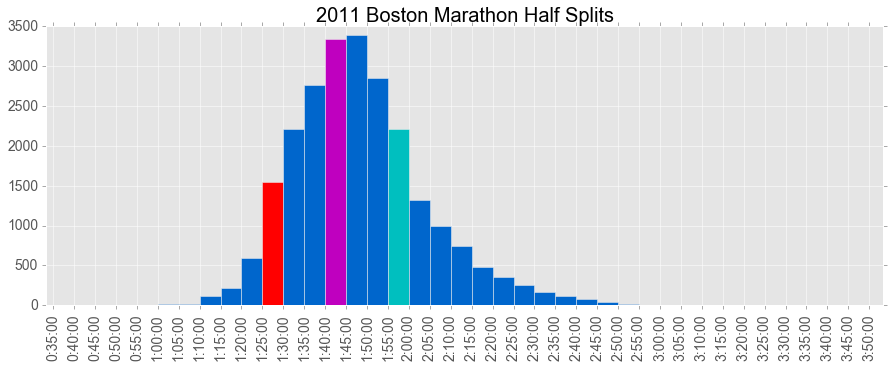

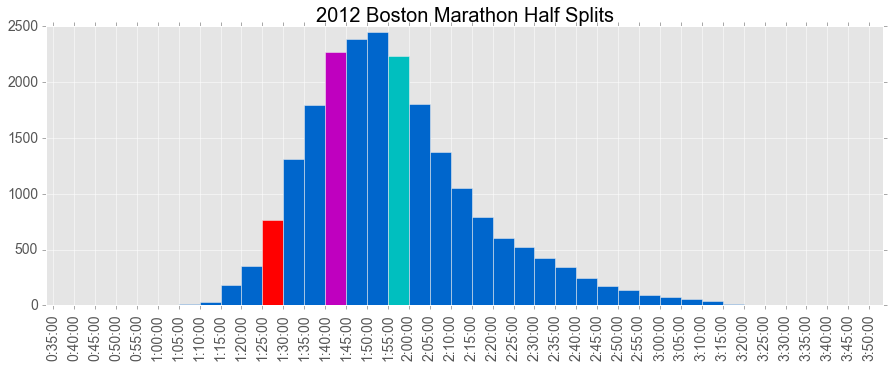

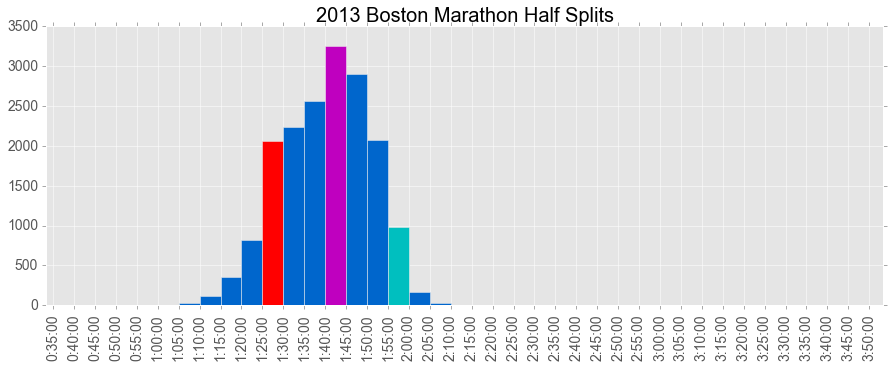

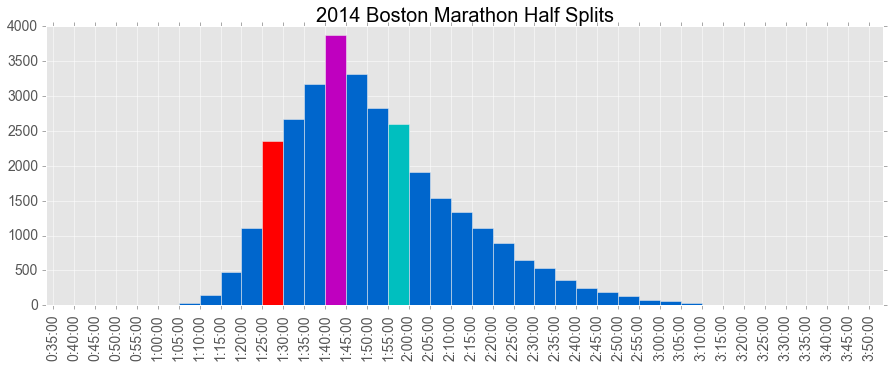

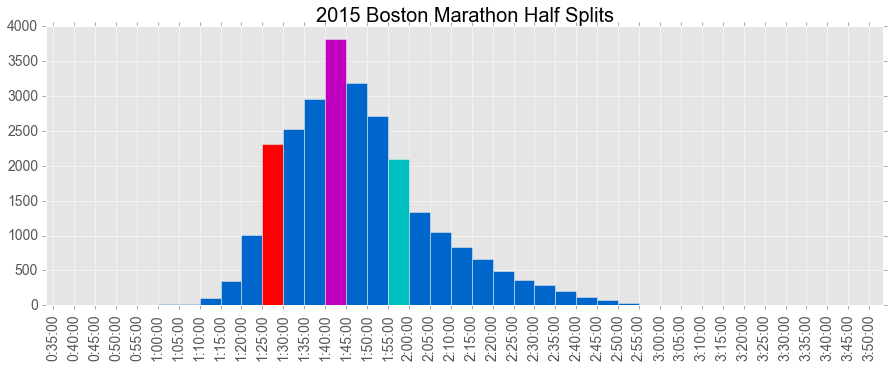

In [15]:
bins = [3000 + i *5*60 for i in range(3*12)]
results['raw_half'] = results.first_half.map(lambda t: t/np.timedelta64(1, 's'))
for year in years:
    pyplot.subplots()
    ax = results[results.year == year].raw_half.hist(
        bins=bins, xrot=90, xlabelsize=14, ylabelsize=14, color=(0, 0.4, 0.8))
    ax.set_title('{} Boston Marathon Half Splits'.format(year))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: str(datetime.timedelta(seconds=x))))
    ax.xaxis.set_major_locator(MultipleLocator(5*60))
    # Highlight {1:30, 1:45, 2:00} bins.
    ax.patches[7].set_facecolor('r')
    ax.patches[10].set_facecolor('m')
    ax.patches[13].set_facecolor('c')

### Commentary

I've highlighted the 1:30, 1:45 and 2:00 marks in the above distributions, to align with projected 3:00, 3:30 and 4:00 finishes.

The most striking feature of the histogram/distribution of half times is that they are much more "smooth" than the overall finishing times. What I mean by "smooth" is that **the bins are always decreasing in value as you move away from the mode**, or the highest bin.

This is in sharp contrast to the distribution of finishing times, where there are sometimes local peaks/modes that correspond to specific goal times that runners were aiming for, i.e. a sub-3 finish. This behaviour has a clear effect on the distribution of finishing times, causing it to reflect runners' goals rather than perhaps their all-out ability.

By contrast, the half-split times look more "natural", but there are still some interesting results: In most years, a lot of runners try to make it under the 1:30 mark at the half, resulting in this bin perhaps being larger than it "should" be. This presumably reflects their goal of running a sub-3-hour marathon.

## Normality of Finishing Times?

*Suggestion by [no_other_plans](https://www.reddit.com/r/running/comments/48rztw/20112015_boston_marathon_results_analysis/d0m2ypo)*

**Note:** *You can safely skip this section if you don't care about statistics.*

An interesting question is: **Are marathon finishing times normally-distributed?** Some other research has pointed towards this, but based on my own observations, I was skeptical of this.

However, I was able to find at least one paper supported the idea that marathon finishing times were normally distributed. El Helou et al. looked at 60 marathon races in their study, *[Impact of Environmental Parameters on Marathon Running Performance](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3359364/)*, and found:

- *"All performances per year and race are normally distributed with distribution parameters (mean and standard deviation) that differ according to environmental factors."*
- *"For each race and each gender every year, we fitted the Normal and log-Normal distributions to the performances and tested the normality and log normality using the Kolmogorov-Smirnov D statistic."*
- *"For all 60 studied races, the women and men's performance distributions were a good approximation of the “log normal” and “normal” distributions (p-values of Kolmogorov-Smirnov statistics ≥0.01)."*

I decided to see if finishing times across the sub-populations of {men, women} and individual age groups (such as M18-39, F40-44, etc.) were normally or log-normally distributed.

In [33]:
# Quick sanity check: Sample 1000 numbers from a normal distribution and calculate the test statistic.
# Should produce a p-value > 0.05.
spstats.mstats.normaltest(np.random.normal(10.0, 1.0, size=1000)) # Mean is 10.0, Std. Dev is 1.0

(1.6209745501660497, 0.44464135077609479)

### Male/Female sub-groups

The distribution of male and female finishing times did not appear to be normally distributed.

In [17]:
min_samples = 200
# raw_finish is the finishing time in seconds; this is the sample we wish to test for normality.
results.groupby(['year', 'gender']).raw_finish\
    .apply(lambda x: (len(x), (spstats.mstats.normaltest(x)[1])) if len(x) >= min_samples else NaN).unstack()

gender,M,W
year,,
2011,"(13806, 0.0)","(10073, 0.0)"
2012,"(12588, 1.75811834612e-277)","(8966, 4.09671981206e-208)"
2013,"(10638, 7.56986820392e-34)","(6942, 9.04889564002e-42)"
2014,"(17523, 0.0)","(14282, 0.0)"
2015,"(14588, 0.0)","(12022, 0.0)"


### Methodology

The p-value calculations were obtained using [`scipy.stats.mstats.normaltest`](http://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.stats.mstats.normaltest.html), which does some super-special-elite-black-ops-ninja normality test based on D'Agostino and Pearson's work. I have no idea whether this normality test is appropriate.

### Explanation

The first number in each cell is the number of samples, and the second is the two-sided p-value from the normality test. So, for example, in 2015 the male age group `n=13806` and `p=0.0`.

The p-value can be interpreted as the answer to this question: Assuming that the distribution is normal (the null hypothesis), what is the probability that the observed/actual distribution would have occurred? If the p-value is sufficiently low (usually either `p < 0.05` or `p < 0.01`) then you conclude the distribution was not normal.

Since the p-values were all extremely small, none of the finishing time distributions for male/female across any of the years I looked at were normally distributed.

### Test for log-normality

If not normal, is the distribution log-normal? It does not appear so either, as the p-values are still very small.

In [18]:
# Apply numpy.log() to the raw_finish distribution and check if the resultant distribution is normal.
results.groupby(['year', 'gender']).raw_finish\
    .apply(lambda x: (len(x), (spstats.mstats.normaltest(np.log(x))[1])) if len(x) >= min_samples else NaN).unstack()

gender,M,W
year,,
2011,"(13806, 1.2614180713e-109)","(10073, 1.98172648771e-116)"
2012,"(12588, 2.30833530703e-44)","(8966, 4.36803851654e-56)"
2013,"(10638, 8.4339201674e-22)","(6942, 6.11833371855e-132)"
2014,"(17523, 2.67790226657e-170)","(14282, 5.02488591682e-125)"
2015,"(14588, 5.13132675067e-202)","(12022, 3.93023975953e-200)"


### Individual Age Groups

If the male/female sub-population finishing times were not normally distributed, what about individual divisions, such as M40-44? Let's take a look:

In [19]:
# Only consider cases where we have more than a minimum of samples.
# Each cell is (num_results, p_value)
min_samples = 200
results.groupby(['year', 'gender', 'age_group']).raw_finish\
    .apply(lambda x: (len(x), spstats.mstats.normaltest(x)[1]) if len(x) >= min_samples else NaN).unstack()

age_group                         18-39                       40-44  \
year gender                                                           
2011 M       (4850, 3.79129982893e-207)   (2303, 5.1737238424e-116)   
     W       (5202, 3.42213901403e-213)   (1807, 1.27611544872e-93)   
2012 M       (4329, 5.92875978114e-135)   (2015, 7.82548468851e-79)   
     W       (4580, 7.76312244648e-118)    (1520, 2.7696416544e-74)   
2013 M        (3772, 1.97364857147e-57)   (1691, 3.48935198605e-14)   
     W        (3832, 3.11057417392e-09)   (1217, 8.57326999618e-10)   
2014 M       (5902, 1.21472771903e-154)   (2623, 3.50856363094e-91)   
     W       (6941, 2.98652592115e-152)   (2325, 1.34215534454e-77)   
2015 M       (4965, 8.69058061792e-267)  (2109, 3.24361423199e-118)   
     W       (6011, 1.61139275085e-244)  (1985, 1.09185624225e-117)   

age_group                         45-49                       50-54  \
year gender                                                           
2011 M       (2556, 1.34168229271e-121)   (1924, 4.84703882793e-86)   
     W        (1591, 1.12978706058e-67)    (854, 7.62680763251e-42)   
2012 M        (2246, 1.21263776287e-95)   (1876, 1.25331051515e-71)   
     W         (1437, 7.1149426582e-58)    (807, 9.67822087938e-25)   
2013 M        (1941, 8.83473044243e-08)   (1581, 0.000170392891304)   
     W        (1060, 1.38582833848e-11)    (551, 1.04171604339e-08)   
2014 M       (2916, 1.22479533154e-136)  (2469, 7.20942824805e-123)   
     W       (2290, 1.74790019953e-105)   (1483, 1.47112280332e-55)   
2015 M       (2485, 2.64851923871e-188)  (2058, 1.77515429255e-155)   
     W        (1831, 7.5598005675e-118)   (1205, 1.15456198475e-65)   

age_group                        55-59                      60-64  \
year gender                                                         
2011 M       (1132, 1.27122358107e-66)   (713, 6.63511276019e-16)   
     W        (396, 2.31327427653e-05)                        NaN   
2012 M       (1078, 7.60836962872e-34)   (685, 1.35282848644e-13)   
     W        (396, 3.69990638511e-05)                        NaN   
2013 M          (1001, 0.362563885165)   (502, 3.32654349822e-05)   
     W        (220, 2.89779898618e-18)                        NaN   
2014 M        (1772, 1.0852929089e-61)  (1100, 5.53126388146e-29)   
     W        (763, 2.27780128126e-23)    (339, 3.2204008091e-08)   
2015 M       (1500, 1.32956139862e-97)   (899, 1.90421031201e-70)   
     W        (606, 9.28545146131e-28)   (270, 8.55173526508e-33)   

age_group                       65-69 70-74 75-79  80+  
year gender                                             
2011 M           (216, 0.02824519562)   NaN   NaN  NaN  
     W                            NaN   NaN   NaN  NaN  
2012 M         (259, 0.0938741508158)   NaN   NaN  NaN  
     W                            NaN   NaN   NaN  NaN  
2013 M                            NaN   NaN   NaN  NaN  
     W                            NaN   NaN   NaN  NaN  
2014 M       (533, 4.33051453826e-11)   NaN   NaN  NaN  
     W                            NaN   NaN   NaN  NaN  
2015 M       (403, 4.90823189202e-12)   NaN   NaN  NaN  
     W                            NaN   NaN   NaN  NaN

### Commentary

I set the minimum number of samples to `200` and assumed that if we had less than this, there weren't enough samples to test for normality or not. (This was entirely arbitrary) Cells that have `NaN` didn't have enough samples to calculate the test statistic.

Again, each cell contains `(number of samples, p-value)` for the specified sub-population. Almost all sub-populations had finishing times for which the p-values were insignificant except for those with smaller numbers of samples.

Visually looking at the distribution of finishing times for a sub-population (such as [M18-39, which I've done below](#How-competitive-is-the-M18-39-age-group?)) also reveals that the times don't appear to be normally distributed.

### Why is this?

I don't know exactly why my result differ so much from [*El Helou et al.*](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3359364/), but here are some possibilities:

- They looked at different races, specifically the {Paris, London, Berlin, Boston, Chicago, New York} marathons from 2001-2010, inclusive, for a total of 60 races. Perhaps sometime has changed in the character of marathon runners since then.
- They are normalizing the finishing times somehow. (I didn't note this in the paper, the only partitioning of the data was by each marathon race and gender)
- My methodology or understanding is fatally flawed or I've made some other huge mistake.

## Success rate of a sub-3 at Boston?

Having the distribution of half and finishing times allows us to make some (*potentially flawed*) inferences about how many runners succeeded in their goal of a sub-3:00 hour marathon at Boston. For this exercise, I'm making the following definitions/assumptions, which may not be true:

- Define "sub-3 runners" as those who were attempting to run *just* a sub-3, i.e. somewhere between 2:55-3:00.
- I assume all runners who were between 1:27:30-1:30:00 at the half were all attempting to run between 2:55-3:00
    - We'll define this as the "sub-3 attempt" group.
    - We exclude those running below 1:27:30 because we assume they were trying to run a sub-2:55, and not just a sub-3:00.
    - This also excludes those that ran a sub-3 negative split, i.e. 1:31/1:28. As we'll see however, there weren't many negative splits in Boston anyways, so excluding this group hopefully doesn't have a huge impact.
    - This also excludes those who attempted a sub-3, but didn't make it to the half in 1:30.
- Define "success" as those in the "sub-3 attempt" group who finished < 3:00 and "failure" as those who finished > 3:00.
- We want to calculate the success rate of this group of runners for each year of the Boston Marathon.

Obviously, this is not an exact calculation and I make no claims to the contrary. However, it's still interesting to look at. (This exercise could be repeated for any goal time, but I chose sub-3:00 because of a personal interest.)

sub_3_achieved,False,True
year,,
2011,716,245
2012,427,32
2013,939,376
2014,1196,275
2015,919,569


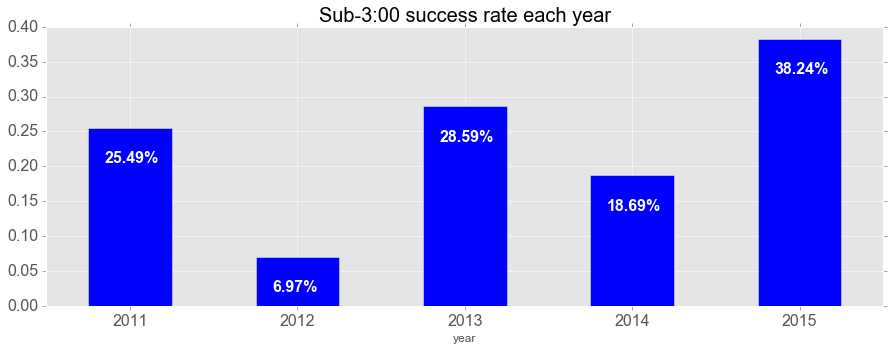

In [20]:
results['sub_3_attempt'] = (results.raw_half >= 60*87.5) & (results.raw_half <= 90*60)
results['sub_3_achieved'] = results.raw_finish < 60*180
sub_3_attempts = results[results.sub_3_attempt].groupby(['year', 'sub_3_achieved']).size().unstack()
ax = sub_3_attempts.div(sub_3_attempts.sum(1), axis=0)[True]\
    .plot(kind='bar', fontsize=16, rot=0, title='Sub-3:00 success rate each year')
for p in ax.patches:
    ax.annotate('{:.2%}'.format(p.get_height()), (p.get_x() + p.get_width()/5, p.get_height() - 0.05), 
                fontsize=16, color='w', weight='bold')
# Display raw data
sub_3_attempts

As expected, the sub-3:00 success rate is correlated with the mean and median finishing times and weather conditions. On cool years (like 2015) the success rate is quite high, while in 2012, the rate was very low.

## How competitive is the M18-39 age group?

We already know that Boston is competitive, but this effect is particularly noticeable in the Male, 18-39 group. My interest in this is partly due to self-centeredness, since this is my own group.

Let's look at the finishing time distribution for just this group:

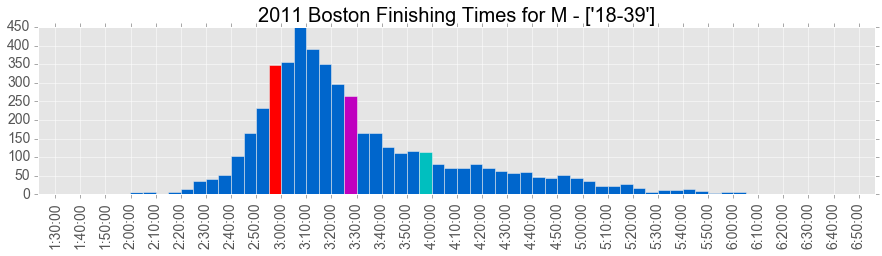

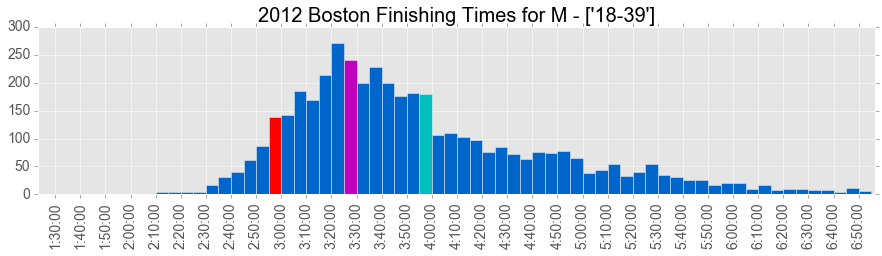

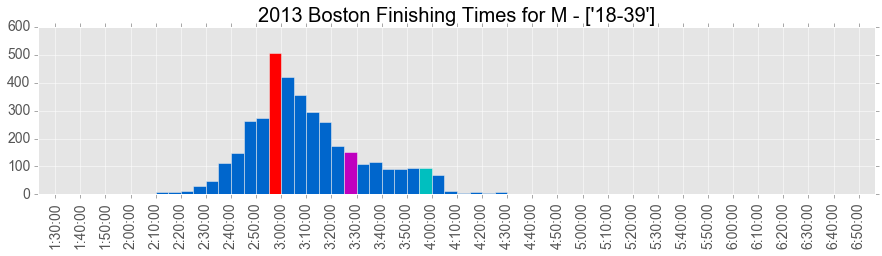

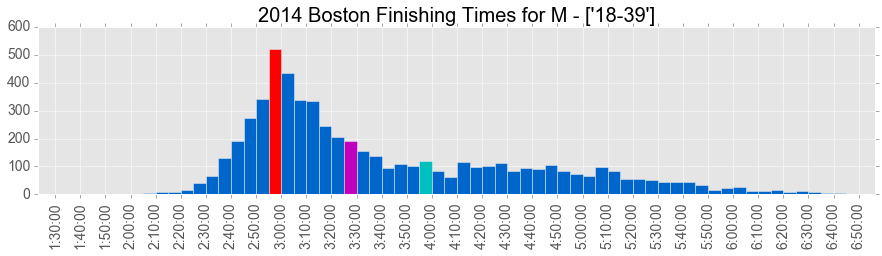

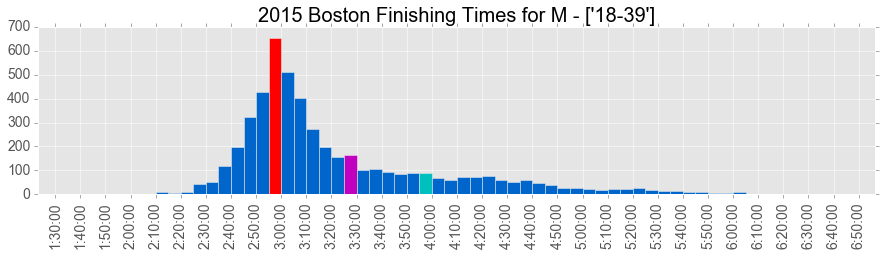

In [21]:
bins = [7200 + i *5*60 for i in range(5*12)]
gender = 'M'
age_groups = ['18-39']
for year in years:
    pyplot.subplots()
    ax = results[(results.year == year) & (results.gender == gender) & (results.age_group.isin(age_groups))].raw_finish.hist(
        bins=bins, xrot=90, xlabelsize=14, ylabelsize=14, color=(0, 0.4, 0.8), figsize=(15, 3))
    ax.set_title('{} Boston Finishing Times for {} - {}'.format(year, gender, age_groups))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: str(datetime.timedelta(seconds=x))))
    ax.xaxis.set_major_locator(MultipleLocator(10*60))
    # Highlight {2:55-3:00, 3:25-3:30 3:55-4:00} bins.
    ax.patches[11].set_facecolor('r')
    ax.patches[17].set_facecolor('m')
    ax.patches[23].set_facecolor('c')

In [22]:
# Display aggregate stats:
results[(results.gender == gender) & (results.age_group.isin(age_groups))].groupby('year').finish\
    .describe(percentiles=[0.1, 0.5]).unstack().reindex(columns=['count', 'mean', '50%', '10%', 'std', 'min', 'max'])\
    .applymap(lambda t: t.to_pytimedelta() if isinstance(t, pd.tslib.Timedelta) else t)

,count,mean,50%,10%,std,min,max
year,,,,,,,
2011,4850,03:29:57.986391,03:18:06.500000,02:51:23.800000,00:40:23.071128,02:03:02,07:37:43
2012,4329,03:55:52.601062,03:42:43,03:01:10.200000,00:51:58.206790,02:12:40,07:16:49
2013,3772,03:10:18.579798,03:05:51,02:45:14,00:22:57.145811,02:10:22,04:42:12
2014,5902,03:41:38.410199,03:19:51,02:47:48.100000,00:56:06.444322,02:08:37,08:54:13
2015,4965,03:22:21.796173,03:06:31,02:46:10,00:41:49.365246,02:09:17,07:00:30


### Commentary

The changes in the finishing time distributions of the M18-39 group reflect the changed standards:
- The median (50%) went from 3:18:07 in 2011 to 3:06:31 in 2015.
- For comparision, the overall median went from 3:44:58 to 3:39:41 over the same time period.
- Thus, it seems that the M18-39 sub-group has gotten more competitive - even moreso than the general Boston Marathon population.
- The most common finishing time in 2011 for this group was sub-3:10, i.e. 3:05-3:10. Since the change in BQ standards, however, the most common finishing time has been sub-3, i.e. 2:55-3:00!

Greatly generalizing, it seems that with the new BQ standards and registration process, **the most common behavioural change of the M18-39 group has been to seek a sub-3:00 finish instead of a sub-3:10 finish**, presumably because that's now the way to get a "guaranteed" qualifier for next year's Boston.

## Negative Splitting Boston: The few, the proud

A negative split is where you run the second half of a race faster than the first half. It's usually considered to be a hallmark of a well-run/well-paced race, because it means you didn't fade at the end.

Very few runners on any given year negative split this course. In fact, for the past few years, **it's always been < 10%**. (My definition of "negative split" used here includes those that even-split the course.)

The reasons are obvious to anyone who has run Boston before: The early downhills quickly give rise to a series of uphills that start around the 26 km mark and don't end until around 33 km, making for a course that is very unforgiving to improper pacing early on, i.e. "going out too fast."

negative_split,False,True
year,,
2011,94.88%,5.12%
2012,98.84%,1.16%
2013,93.46%,6.54%
2014,97.48%,2.52%
2015,92.32%,7.68%


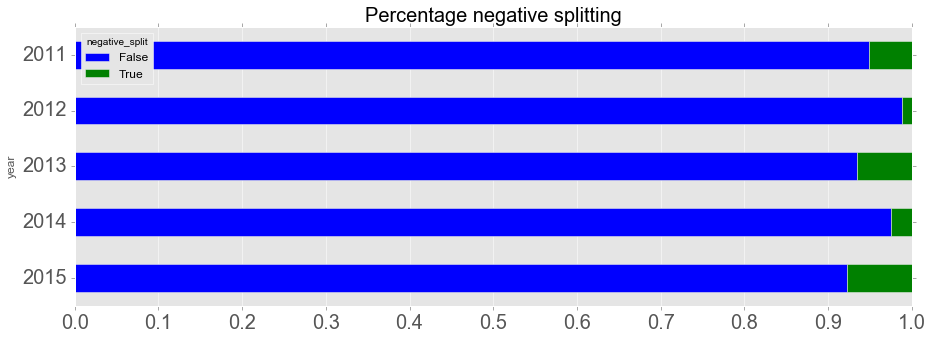

In [23]:
results['negative_split'] = (results.second_half <= results.first_half)
year_negative_split = results.groupby(['year', 'negative_split']).size().unstack()
year_negative_split_normed = year_negative_split.div(year_negative_split.sum(1), axis=0)
ax = year_negative_split_normed.plot(kind='barh', stacked=True, title='Percentage negative splitting', fontsize=20)
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.invert_yaxis()
year_negative_split_normed.applymap(lambda x: '{:.2%}'.format(x))

## Negative splitting by gender
*Suggestion by [kkruns](https://www.reddit.com/r/running/comments/48rztw/20112015_boston_marathon_results_analysis/d0m6gal)*

There did not appear to be a marked difference between the negative-split success rate of men vs. women. In all years, the difference was less than 1%.

negative_split   False  True 
year gender                  
2011 M          95.08%  4.92%
     W          94.61%  5.39%
2012 M          99.01%  0.99%
     W          98.61%  1.39%
2013 M          93.70%  6.30%
     W          93.09%  6.91%
2014 M          97.31%  2.69%
     W          97.68%  2.32%
2015 M          92.27%  7.73%
     W          92.38%  7.62%

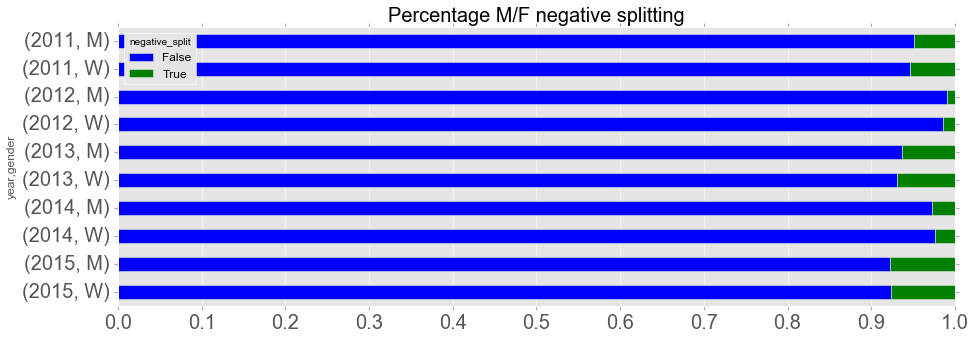

In [24]:
results['negative_split'] = (results.second_half <= results.first_half)
year_gender_negative_split = results.groupby(['year', 'gender', 'negative_split']).size().unstack()
year_gender_negative_split_normed = year_gender_negative_split.div(year_gender_negative_split.sum(1), axis=0)
ax = year_gender_negative_split_normed.plot(kind='barh', stacked=True, title='Percentage M/F negative splitting', fontsize=20)
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.invert_yaxis()
# Show raw results:
year_gender_negative_split_normed.applymap(lambda x: '{:.2%}'.format(x))

### Relaxing the definition of "negative split"

What if we ease the definition of a "negative split" to mean those that ran the second-half within **one minute** of the first-half? For example, under this definition we would consider someone who ran a 1:30/1:31 on their way to a 3:01 finish as someone who "negative split" the course.

Even with this grace period, the percentage of negative splitters is not much better. In fact, it's not until we increase the grace period to 100 seconds that the number of "negative splitters" rises above 15% even in an ideal year like 2015.

If you have failed to negative split Boston (like yours truly), you should not feel bad: Most people probably have not.

negative_split_relaxed,False,True
year,,
2011,92.03%,7.97%
2012,98.28%,1.72%
2013,89.46%,10.54%
2014,95.81%,4.19%
2015,88.07%,11.93%


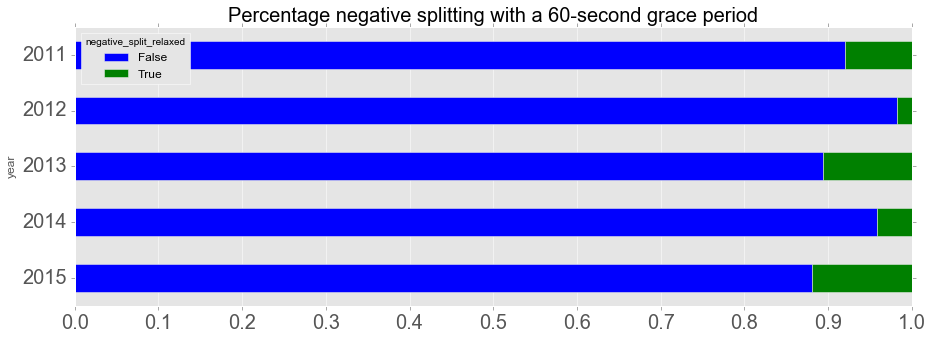

In [25]:
grace_period = 60
results['negative_split_relaxed'] = (results.second_half <= (results.first_half + datetime.timedelta(seconds=grace_period)))
year_negative_split = results.groupby(['year', 'negative_split_relaxed']).size().unstack()
year_negative_split_normed = year_negative_split.div(year_negative_split.sum(1), axis=0)
ax = year_negative_split_normed.plot(
    kind='barh', stacked=True, fontsize=20,
    title='Percentage negative splitting with a {}-second grace period'.format(grace_period))
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.invert_yaxis()
year_negative_split_normed.applymap(lambda x: '{:.2%}'.format(x))

## For fun: Beating your bib number

How many runners "beat" their bib number, i.e. finished in an overall place better than their bib number? This may sometimes be a goal, as bib numbers are assigned sequentially in order of qualifying times.

For example, a person assigned with a bib number of 1000 qualified with a faster time than a person assigned a bib number of 2000. So, if you started with a bib of 2000 and finished in 1000th place, you "beat" a lot of other runners who qualified with a faster time than you.

(It should be noted that bib numbers for non-elites appear to start at 101, so this would seem to make it harder to beat your bib)

In [26]:
# For fun: How many runners "beat" their bib number?
# NOTE: Messy, because have to deal with missing/non-numeric data in bibs.
results['bib_numeric'] = results.bib.map(lambda x: int(x) if (not pd.isnull(x) and x.isdigit()) else np.nan)
results['finish_beat_bib'] = results.place < results.bib_numeric

finish_beat_bib,False,True
year,,
2012,5056,16498
2013,4451,13129
2014,9928,21877
2015,5917,20693


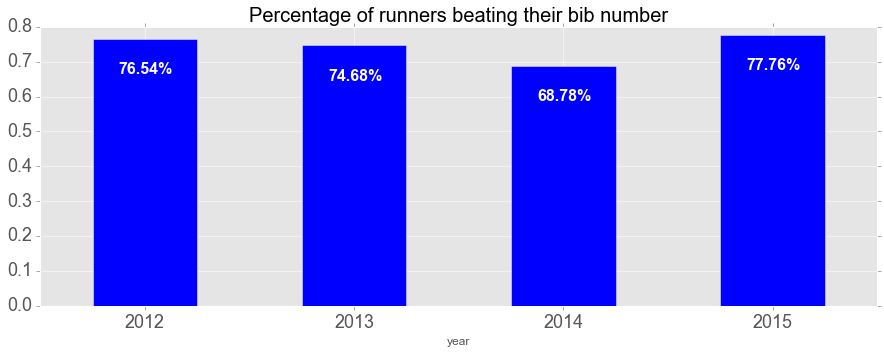

In [27]:
# NOTE: No bib numbers for 2011.
finish_beat_bib = results[results.year != 2011].groupby(['year', 'finish_beat_bib']).size().unstack()
ax = finish_beat_bib.div(finish_beat_bib.sum(1), axis=0)[True]\
    .plot(kind='bar', fontsize=18, title='Percentage of runners beating their bib number', rot=0)
for p in ax.patches:
    ax.annotate('{:.2%}'.format(p.get_height()), (p.get_x() + p.get_width()/4, p.get_height() - 0.1), 
                fontsize=16, color='w', weight='bold')
finish_beat_bib

### Explanation
The high percentage of runners beating their bib numbers each year seems suspect, but upon further examination, it's not unusual. Let me explain:

1. There number of runners who register and get a bib is typicaly a few thousand more than the number that actually finish, due to injury or other unexpected circumstance. (See the [2015 official statistics](http://registration.baa.org/2015/cf/Public/iframe_Statistics.htm) for an example)
2. All it takes is a few "fast" runners with low bib numbers to not finish, or finish far back, in order to "bump up" a lot of runners with higher bib numbers. Thus, just a few low-bib runners who fall back is enough to cause a large number of runners to finish "ahead" of their bib number.
3. The effect in (2) far outweighs the fact that non-elite bibs don't start until 101.

**However, it should be noted that I have only beat my bib number once**, in 2012. So, just because it's easy for runners as a whole, doesn't mean it's easy for me!

In [28]:
results[results.name.str.contains('Chng') & results.finish_beat_bib][['year', 'place', 'name', 'bib', 'finish']]

,year,place,name,bib,finish
25486,2012,3052,"Chng, Peter",3179,03:29:51
